In [1]:
# tests/test_sedov_amr.py

import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import jax 
jax.config.update('jax_disable_jit', True)
jax.config.update('jax_debug_nans', True)

import sys
import jax
import jax.numpy as jnp
import numpy as np

import diffhydro as dh
from diffhydro.prob_gen.initial_conditions import sedov_2d
from diffhydro.utils.diagnostics import isotropy_score


In [2]:
def run_solver(U0, params, *, steps=30, dt=0.2, use_amr=False, adapt_interval=1, refine_ratio=2):
    # Matches your hydro() interface; enable AMR via the new knobs
    hydro = dh.hydro(
        n_super_step=steps,
        fluxes=[dh.ConvectiveFlux(dh.equationmanager.EquationManager(),
                                  dh.LaxFriedrichs(equation_manager=dh.equationmanager.EquationManager(),
                                          signal_speed=dh.signal_speed_Rusanov),
                                  dh.MUSCL3(limiter="SUPERBEE"))],
        max_dt=dt,
        maxjit=False,
        use_amr=use_amr,
        adapt_interval=adapt_interval,
        refine_ratio=refine_ratio,
        splitting_schemes=[[1,2,2,1],[2,1,1,2]]
    )
    fs = hydro.evolve(U0, params)
    return fs, hydro._amr_trace

def center_patch(x, pad):
    return x[..., pad:-pad, pad:-pad]

# ------------- tests -------------
def test_amr_conserves_mass_short_rollout():
    # Setup like tests/test_sedov.py, but short and AMR-enabled
    eq = dh.equationmanager.EquationManager()
    eq.box_size = (1.0, 1.0, 1.0)
    U0, _ = sedov_2d(1e7, 0.1, eq)   # same IC style as your sedov test :contentReference[oaicite:3]{index=3}

    params = {}

    U1, _ = run_solver(U0, params, steps=20, dt=0.2, use_amr=True, adapt_interval=1, refine_ratio=2)

    m0 = jnp.sum(U0[0])
    m1 = jnp.sum(U1[0])

    # Until refluxing is fully wired, keep tolerance modest; tighten later.
    assert jnp.allclose(m0, m1, rtol=1e-3, atol=1e-5), f"Mass drift: {float(m0)} → {float(m1)}"


In [3]:


def make_gaussian_blob(
    eq,
    shape,
    peak_temp: float = 10.0,
    background_temp: float = 1.0,
    sigma: float = 3.0,
):
    """Generate a 3-D Gaussian temperature perturbation in conservative form."""

    nx, ny = shape
    sol = jnp.zeros((5, nx, ny))
    rho0 = 1.0
    sol = sol.at[0].set(rho0)

    grid = [(jnp.arange(n) + 0.5) - 0.5 * n for n in (nx, ny)]
    X, Y = jnp.meshgrid(*grid, indexing="ij")
    r2 = X**2 + Y**2 

    delta_T = peak_temp - background_temp
    temperature = background_temp + delta_T * jnp.exp(-r2 / (2.0 * sigma**2))

    pressure = rho0 * eq.R * temperature
    total_energy = eq.get_total_energy(
        pressure,
        rho0 * jnp.ones_like(pressure),
        jnp.zeros_like(pressure),
        jnp.zeros_like(pressure),
        jnp.zeros_like(pressure),
    )
    sol = sol.at[-1].set(total_energy)

    return sol, temperature

In [4]:

eq = dh.equationmanager.EquationManager()
eq.mesh_shape=[128,128,128]
eq.box_size = (1.0, 1.0, 1.0)

UG = make_gaussian_blob(eq,[128,128])[0]

2025-10-11 09:53:18.255149: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a reco

In [5]:

eq = dh.equationmanager.EquationManager()
eq.box_size = (1.0, 1.0, 1.0)
eq.mesh_shape=[128,128,128]
r = 2

#Uc, _ = sedov_2d(1e7, 0.1, eq,embed_in_3d=False)
# Uniform fine “reference”

# After (works for 2D or 3D):
#C = Uc.shape[0]
#spatial = Uc.shape[1:]                                  # (H,W) or (Z,H,W)
#target = (C,) + tuple(s * r for s in spatial)
#Uf0 = jax.image.resize(Uc.astype(jnp.float32), target, method="linear", antialias=True)
params = {}


In [ ]:
Uamr,amr_traceamr = run_solver(UG,  params, steps=4, dt=0.2, use_amr=True, adapt_interval=1, refine_ratio=r)


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


evolve
no, maxjit?
AMR!


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring f

'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


min/max rho: 1.0 1.0
total rho: 16384.0


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


any NaN in state? False


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring f

dt [Array(0.02531402, dtype=float32), 10000000000.0]


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring f

AMR!
refine! 48 32


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


refine! 64 32
refine! 80 32
refine! 32 48
refine! 48 48
refine! 64 48
refine! 80 48
refine! 32 64
refine! 48 64
refine! 64 64
refine! 80 64
refine! 32 80
refine! 48 80
refine! 64 80
refine! 80 80
min/max rho: 0.9851303696632385 1.0065972805023193
total rho: 16383.9990234375
any NaN in state? False
dt [Array(0.02477225, dtype=float32), 10000000000.0]


In [ ]:
eq.vel_ids #16384.0

In [ ]:
Uamr[0][0].sum(),UG[0].sum()

Populating the interactive namespace from numpy and matplotlib


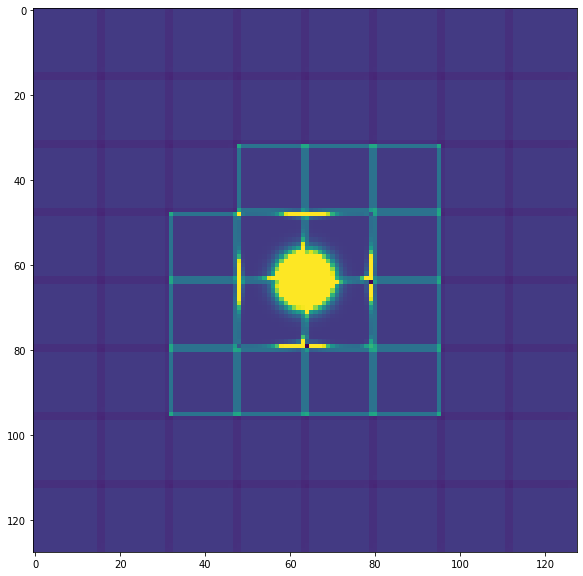

In [21]:
%pylab inline
figure(figsize=(10,10))
imshow(Uamr[0][-1],vmax=3)

In [ ]:
%pylab inline
figure(figsize=(10,10))
imshow(Uamr[0][-1]-UG[-1],vmax=3)

In [ ]:
Uamr_no,amr_traceamr_no = run_solver(Uc,  params, steps=20, dt=0.2, use_amr=False, adapt_interval=1, refine_ratio=r)


In [ ]:
%pylab inline

imshow(Uamr[0][0])

In [ ]:
%pylab inline
imshow(Uamr_no[0][0])

In [ ]:
imshow(amr_traceamr["first_refined_step"])

In [ ]:
np.array(amr_traceamr['depth_maps']).max()

In [ ]:
Uf, amr_tracef = run_solver(Uf0, params, steps=100, dt=0.2, use_amr=False)


In [ ]:
np.array(amr_traceamr['depth_maps']).sum()

In [ ]:
%pylab inline
imshow(Uamr[0][0])

In [ ]:
%pylab inline
imshow(Uf[0][0])

In [ ]:
Uamr.shape

In [ ]:
from scipy import ndimage
# Compare on refined region: upsample AMR output to the fine grid
Uamr_up = jax.image.resize(Uamr[0], (C,200,200), method="linear")
pad = 8 * r  # avoid boundaries
ref = center_patch(Uf[0], pad)
tst = center_patch(Uamr_up[0], pad)

rel = float(jnp.linalg.norm(tst - ref) / (jnp.linalg.norm(ref) + 1e-8))
#    assert rel < 0.20, f"AMR vs fine mismatch too large: {rel:.3f} (tighten after refluxing)"
print(rel)

In [ ]:
eq = dh.equationmanager.EquationManager()
eq.box_size = (1.0, 1.0, 1.0)

def loss_fn(logE):
    E = jnp.exp(logE)  # keep positivity
    U0, _,_ = sedov_2d(E, 0.1, eq)          # your sedov_2d IC :contentReference[oaicite:4]{index=4}
    U1, _,_ = run_solver(U0, {}, steps=10, dt=0.2, use_amr=True, adapt_interval=2, refine_ratio=2)
    # Use your isotropy metric on a central slice like in test_sedov.py :contentReference[oaicite:5]{index=5}
    iso = isotropy_score(np.asarray(U1[0][:, U1.shape[-2] // 2, :]))
    return jnp.asarray(iso, dtype=jnp.float32)

g = jax.grad(loss_fn)(jnp.log(1e7))
g_val = float(g)